In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import imageio
from torch import nn
%matplotlib inline

## Problem definition
Suppose we have a time series P(t). P(t) is the solution of a differential equation $$ \frac{dP}{dt} = f(t,P(t))$$ We don't know the differential equation, nor the solution-time series P(t). We have some points (ti, pi) but not P(t). 

## time series - sine data


Let's suppose a simple example, P(t) = sint, which is solution of diff.eq P'(t) = cost. 
##### We pretend like we don't know P(t), just some points (ti,pi), specifically we have 100 points in (-10,10).

# First approach :
One first approach is to approximate P(t) with interpolation, for example a Neural Network. We can use also other models like splines. Neural Network is a continues function approximator with great results, for this reason is a good choice. 

#### model 2
is nn.Sequential with 200 neurons in hidden layer, it's the same with model 1 but written in other way:

In [49]:
#define model 2
net2 = torch.nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.Sigmoid(),
        torch.nn.Linear(50, 1),
    )
optimizer = torch.optim.Adam(net2.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss() 

In [50]:
x = torch.unsqueeze(torch.linspace(-5, 5, 100), dim=1) 

y = torch.sin(x) + 0.2*torch.rand(x.size()) 

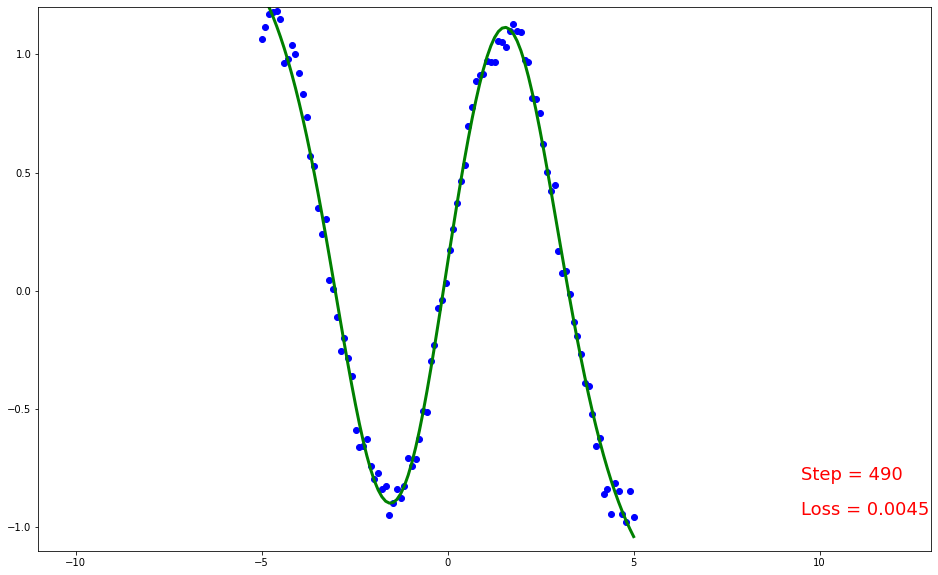

In [51]:
#training
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
losses=[]
for t in range(500):
  
    prediction = net2(x)     # input x and predict based on x

    loss = loss_func(prediction, y) 
    losses.append(loss)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if t % 10 == 0:
        # plot and show learning process
        plt.cla()
        ax.set_xlim(-11.0, 13.0)
        ax.set_ylim(-1.1, 1.2)
        ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
        ax.text(9.50, -0.8, 'Step = %d' % t, fontdict={'size': 18, 'color':  'red'})
        ax.text(9.50, -0.95, 'Loss = %.4f' % loss.data.numpy(),
                fontdict={'size': 18, 'color':  'red'})

        # Used to return the plot as an image array 
        # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)
    
    


# save images as a gif    
imageio.mimsave('./curve_2_bignet.gif', my_images, fps=10)

In [159]:
#we want to store the model that we train!
torch.save(net2.state_dict(),"net_sinx.pth")
print("model trained and stored at net_six.pth")

model trained and stored at net_six.pth


In [52]:
len(y)

100

In [53]:
loss_func(prediction,y)

tensor(0.0044, grad_fn=<MseLossBackward>)

In [54]:
loss_func(net2(x), y)

tensor(0.0044, grad_fn=<MseLossBackward>)

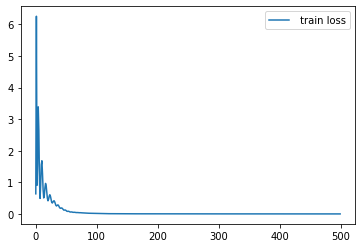

In [55]:
plt.plot(losses, label =' train loss') 
plt.legend()
plt.show()

### Make predictions

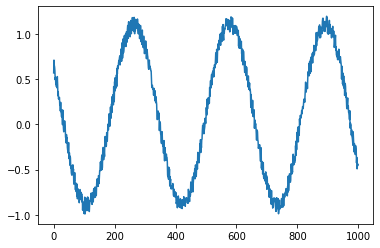

In [56]:
x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  #1000 points, so 900 new points

y = torch.sin(x) + 0.2*torch.rand(x.size())  
x, y = Variable(x), Variable(y)
plt.plot(y)

In [57]:
pred = net2(x)
loss = loss_func(pred, y)
loss 

tensor(1.5221, grad_fn=<MseLossBackward>)

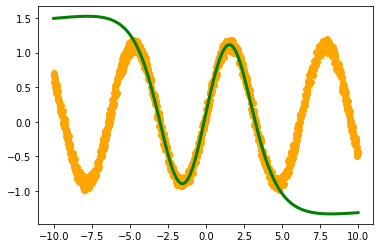

In [58]:
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)

We can see that we trained the model in 100 points with t in T=(-10,10) and it works very good also for 1000 points in T. We have now an approximator of time series P(t). Although, if we try the model out of T, we see that it works good for data in T, but it's very bad for data out of T! So, it is not reliable for future predictions of time t:

In [14]:
d= net2(x)-y
d=d.detach().numpy()
abs(np.mean(d))

0.11815849

# Second approach:
One second approach is to use the approximation of P(t) that we found(i.e the avove Neural Network), so P(t) = N(t). Also,
1. As we said, Neural Network is a continues approximator, so we can have the derivative $\frac{dN}{dt}$
2. P(t) = N(t) is the solution of a diff. eq. $$\frac{dP}{dt} = f(t,P(t))$$ which we don't know.
3. suppose $$\frac{dP}{dt} = N1(t) * N(t)$$ where N1(t) is an other Neural Network that we have to train.
4. We want to minimize the loss function $$ E= \frac{1}{2}[\frac{dN}{dt} - N1(t)N(t)]^{2} $$ 


In [59]:
net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 500),
        torch.nn.Sigmoid(),
        torch.nn.Linear(500, 1),
    )
net1 = net1.float()

In [60]:
def loss(x):

    x.requires_grad = True
    N = net2(x)
    dN_dx = torch.autograd.grad(N, x, grad_outputs=torch.ones_like(N),
                        create_graph=True)[0]

    return  torch.mean( ( dN_dx - net1(x)*net2(x) )  ** 2)

In [61]:
optimizer = torch.optim.Adam(net1.parameters(), lr=0.01)

#optimizer = torch.optim.Adam(net1.parameters()) #The optimizer used in paper was BFGS
#x = torch.Tensor(np.linspace(-10, 10, 150)[:, None]) 
#net1 = net1.float()

In [62]:
losses=[]

In [63]:
x = torch.unsqueeze(torch.linspace(-5, 5, 1000), dim=1)  #1000 points, so 900 new points

In [65]:
def closure():
    
    l = loss(x)
    losses.append(l)
    
    optimizer.zero_grad()
    l.backward()
    print(f"loss: {l}")
    return l

for i in range(2000):
    optimizer.step(closure)

loss: 0.12755967676639557
loss: 0.12747210264205933
loss: 0.12739047408103943
loss: 0.1273159384727478
loss: 0.12724773585796356
loss: 0.12718406319618225
loss: 0.12712255120277405
loss: 0.1270611733198166
loss: 0.12699832022190094
loss: 0.12693308293819427
loss: 0.12686531245708466
loss: 0.12679524719715118
loss: 0.12672357261180878
loss: 0.12665103375911713
loss: 0.12657833099365234
loss: 0.12650595605373383
loss: 0.12643440067768097
loss: 0.1263638138771057
loss: 0.12629422545433044
loss: 0.12622562050819397
loss: 0.12615782022476196
loss: 0.12609067559242249
loss: 0.12602408230304718
loss: 0.12595783174037933
loss: 0.1258918195962906
loss: 0.12582603096961975
loss: 0.12576036155223846
loss: 0.12569481134414673
loss: 0.12562939524650574
loss: 0.12556412816047668
loss: 0.12549903988838196
loss: 0.12543419003486633
loss: 0.12536966800689697
loss: 0.12530554831027985
loss: 0.1252419799566269
loss: 0.12517912685871124
loss: 0.1251172125339508
loss: 0.12505654990673065
loss: 0.1249975785

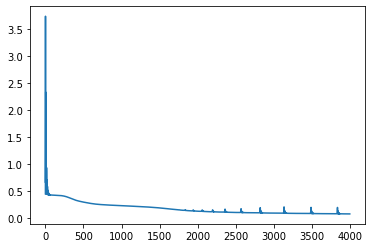

In [66]:
plt.plot(losses)
plt.show()

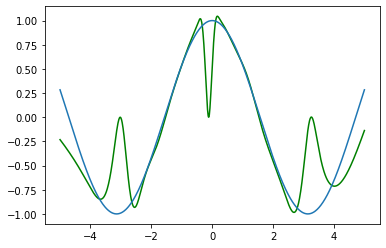

In [67]:
pred = net1(x)*net2(x)
cos = torch.cos(x)
plt.plot(x.data.numpy(), pred.data.numpy(), 'g-')
plt.plot(x.data.numpy(), cos.data.numpy())

### Step 2: solution of diff.eq.
We have $$\frac{dP}{dt}= N1(t)*N(t) = f(t, P(t))$$ , we can solve this diff. eq with a Neural Network(numericaly) or with any other numerical way.

In [ ]:
#(0,10) 
#t0 --- > net(t0) = A
#sigmoid
#less hidden neurons

In [68]:
x = torch.Tensor(np.linspace(-5, 5, 150)[:, None]) 

In [69]:
NN = nn.Sequential(nn.Linear(1, 200), nn.Sigmoid(), nn.Linear(200,1))
A =net2(x[0])
Psi_t = lambda x: A + (x+5)*NN(x)
f = lambda x: net1(x)*net2(x)

In [70]:
def loss_fun(x):

    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]

    return  torch.mean( ( Psi_t_x - f(x) )  ** 2)

In [71]:
optimizer = torch.optim.Adam(NN.parameters(), lr=0.01)

In [72]:
losses_N=[]

In [73]:
def closure():

    optimizer.zero_grad()
    l = loss_fun(x)
    losses_N.append(l)
    print(l)
    #l.backward()
    l.backward(retain_graph=True)
    return l

for i in range(300):
    optimizer.step(closure)

tensor(0.4395, grad_fn=<MeanBackward0>)
tensor(1.4264, grad_fn=<MeanBackward0>)
tensor(0.4005, grad_fn=<MeanBackward0>)
tensor(0.4104, grad_fn=<MeanBackward0>)
tensor(0.7435, grad_fn=<MeanBackward0>)
tensor(0.5359, grad_fn=<MeanBackward0>)
tensor(0.1959, grad_fn=<MeanBackward0>)
tensor(0.1425, grad_fn=<MeanBackward0>)
tensor(0.3163, grad_fn=<MeanBackward0>)
tensor(0.3888, grad_fn=<MeanBackward0>)
tensor(0.2705, grad_fn=<MeanBackward0>)
tensor(0.1307, grad_fn=<MeanBackward0>)
tensor(0.1196, grad_fn=<MeanBackward0>)
tensor(0.2085, grad_fn=<MeanBackward0>)
tensor(0.2606, grad_fn=<MeanBackward0>)
tensor(0.2178, grad_fn=<MeanBackward0>)
tensor(0.1454, grad_fn=<MeanBackward0>)
tensor(0.1255, grad_fn=<MeanBackward0>)
tensor(0.1614, grad_fn=<MeanBackward0>)
tensor(0.1908, grad_fn=<MeanBackward0>)
tensor(0.1720, grad_fn=<MeanBackward0>)
tensor(0.1278, grad_fn=<MeanBackward0>)
tensor(0.1066, grad_fn=<MeanBackward0>)
tensor(0.1212, grad_fn=<MeanBackward0>)
tensor(0.1394, grad_fn=<MeanBackward0>)


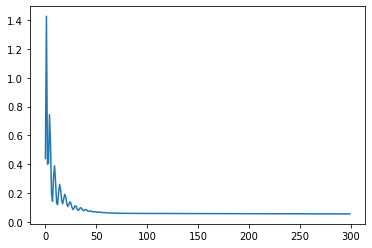

In [74]:
plt.plot(losses_N)
plt.show()

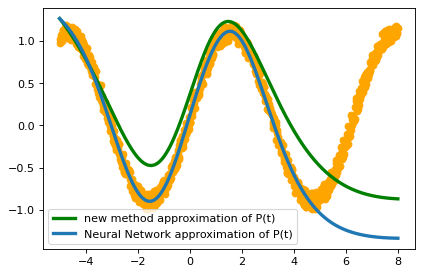

In [75]:
x = torch.unsqueeze(torch.linspace(-5, 8, 800), dim=1) 
y = torch.sin(x) + 0.2*torch.rand(x.size())  
p_t_second = Psi_t(x)
p_t_first = net2(x)
fig, ax = plt.subplots(dpi=80)
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), p_t_second.data.numpy(), 'g-', lw=3, label ='new method approximation of P(t)')
ax.plot(x.data.numpy(), p_t_first.data.numpy(), lw=3, label ='Neural Network approximation of P(t)')
#ax.plot(x.data.numpy(), yrk, lw=3, label ='RK approximation of P(t)')

plt.legend(loc='best');

# Solution of O.D.E with RK method:
I have the O.D.E $$ \frac{dy}{dt} = N1(t)*N(t) = f(t,y(t)) ,y =p(t)$$
The RK methods is:  
1. $$ k1 = f(tn,yn) = N1(tn)*N(tn) $$
2. $$ k2 = f(tn+\frac{h}{2}, yn+h\frac{k1}{2}) = N1(tn+\frac{h}{2})* N(tn+\frac{h}{2})$$
3. $$ k3 = f(tn+\frac{h}{2}, yn+h\frac{k2}{2}) = N1(tn+\frac{h}{2})* N(tn+\frac{h}{2})$$
4. $$ k4 = f(tn+h, yn+hk3) = N1(tn+h)* N(tn+h) $$
So, $$y^{n+1} = y^{n} +\frac{1}{6}(k1+2k2+2k3+k4)$$

In [76]:
x = torch.unsqueeze(torch.linspace(-5,5, 1000), dim=1) 
N = len(x)
h = (5+5)/N

In [77]:
yrk = np.zeros(int(N))
yrk[0]=net2(x[0])
for i in range(0,int(N-1)):
    k1 = net1(x[i])*net2(x[i])
    k2 = net1(x[i]+(h/2))*net2(x[i]+(h/2))
    k3 = net1(x[i]+(h/2))*net2(x[i]+(h/2))
    k4 = net1(x[i]+h)*net2(x[i]+h)

    yrk[i+1] = yrk[i] + (1/6)*h*(k1+2*k2+2*k3+k4)

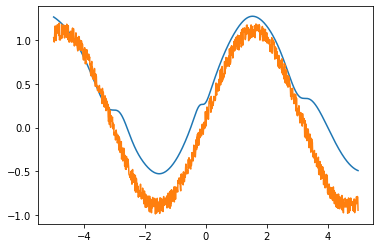

In [78]:
y = torch.sin(x) + 0.2*torch.rand(x.size()) 
plt.plot(x,yrk)
plt.plot(x,y)
plt.show()

In [70]:
y_num = y.detach().numpy()
abs(np.mean(y_num-yrk))

0.11766616111714392